# Let's compare accuracy of some models

## Import the necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
from helpers.accuracy_functions import return_batch_accuracy, return_ds_accuracy
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pickle

## Import the data

In [3]:
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 11)

## Global Parameters

In [4]:
MAX_EPOCHS = 50
PATIENCE = 10
LSTM_LAYER_SIZE = 64
DENSE_LAYER_SIZE = 128
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
DS_LOCATION = "data/pickle/ds_creation_d/calc_before_all_f.pickle"

NOISE_STD = .15
N_REPEATS = 7
SEQ_IN_LENGTH = 5
SEQ_OUT_LENGTH = 1

## Training the models

### Baseline: no extra features

#### Create Dataset 

In [ ]:
extra_features_dict = {}

# Load data in order to not need to do calculations again
with open(DS_LOCATION, 'rb') as handle:
    my_ds_creation_dict = pickle.load(handle)

my_ds = TFDataSet.init_as_fixed_length(scene_data.traj_dataframe, scale_list=["pos_x", "pos_y"], seq_in_length=SEQ_IN_LENGTH, label_length=SEQ_OUT_LENGTH, seq_stride=1,
extra_features_dict=extra_features_dict, ds_creation_dict=my_ds_creation_dict, noise_std=NOISE_STD, n_repeats = N_REPEATS)

#### Create Model

In [31]:
my_trainer_basic = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
network = my_trainer_basic.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=[])

save_path = "data/model_weights/m_no_extra_f.h5"

try:
    my_trainer_basic.load_weights(save_path)
except:
    my_trainer_basic.compile_and_fit(my_ds, save_path)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 61,826
Trainable params: 61,826
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/50
924/924 [==============================] - 16s 12ms/step - loss: 0.0651 - mean_absolute_error: 0.1836 - val_loss: 0.0330 - val_mean_absolute_error: 0.1374
Epoch 2/50
924/924 [==============================] - 8s 9ms/step - loss: 0.0126 - mean_absolute_error: 0.0837 - val_loss: 0.0070 - val_mean_absolute_error: 0.0609
Epoch 3/50
924/924 [==============================] - 10s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0048 - val_mean_absolute_error: 0.0509
Epoch 4/50
924/924 [==============================] - 9s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0423 - va

### Added Feature: All Destinations

In [ ]:
my_trainer_all_dests = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
network = my_trainer_all_dests.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"])

save_path = "data/model_weights/m_all_dests.h5"

try:
    my_trainer_all_dests.load_weights(save_path)
except:
    my_trainer_all_dests.compile_and_fit(my_ds, save_path)

### Added feature: All points

In [ ]:
my_trainer_all_points = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
network = my_trainer_all_points.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_points"])

save_path = "data/model_weights/m_all_points.h5"

try:
    my_trainer_all_points.load_weights(save_path)
except:
    my_trainer_all_points.compile_and_fit(my_ds, save_path)

## Getting some accuracy stats

### Baseline


In [45]:
# Get an example path   
normed, denormed = my_ds.example_dict("test", "in_xy")
my_in_n, my_out_n = normed
my_in, my_out = denormed

In [62]:
# Do a prediction
# Do a prediction
predicted_out_n, predicted_out = my_trainer_basic.predict_dict(my_in_n, False)
predicted_rep_out = my_trainer_basic.predict_repetitively_dict(my_in_n, False, 10, True)

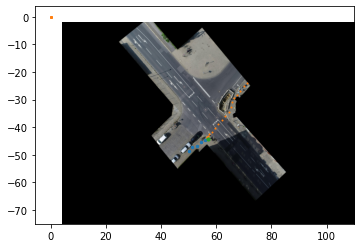

In [63]:
fig1, ax1 = plt.subplots()
id = 1
scene_data.plot_on_image([my_in["in_xy"][id], my_in["labels"][id], predicted_out[id]], 
save_path='data/images/extra_f/in_out.png', ms = [6, 1, 10], ax=ax1,
col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict, my_ds.generalised_out_dict])

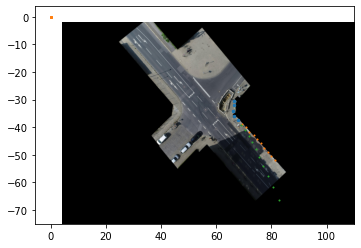

In [73]:
fig2, ax2 = plt.subplots()
id = 4
scene_data.plot_on_image([my_in["in_xy"][id], my_in["labels"][id], predicted_rep_out[id]], 
save_path='data/images/extra_f/in_out.png', ms = [6, 1, 1], ax=ax2,
col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict, my_ds.generalised_out_dict])

In [68]:
return_batch_accuracy(predicted_rep_out, my_in["labels"])

([3.792595140862788,
  7.281773814383878,
  1.1824175900614335,
  7.105676426235156,
  5.4867970494494624],
 [10, 10, 10, 10, 10])

### Extra feature: Destination predictions